## Preliminaries

### Packages & Libraries

In [1]:
%%bash

rm -rf delta
unzip -u -q delta.zip

<br>

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)


<br>

**Libraries**

In [4]:
import logging
import collections
import pathlib
import requests

import os

import pickle
import json
import theano

import numpy as np
import pandas as pd
import re
import dask

import sklearn.decomposition

import pymc3
import graphviz
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pymc3.__version__

'3.11.2'

In [6]:
dask.__version__

'2.30.0'

<br>

### Logging

In [7]:
logging.basicConfig(level=logging.WARNING, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [8]:
import delta.error.frequencies
import delta.error.derivations

import delta.graphing.relational
import delta.graphing.settings
import delta.graphing.error

import delta.algorithms.inspect
import delta.algorithms.scale
import delta.algorithms.preprocessing

import delta.binary.overarching
import delta.binary.disaggregates

import delta.binary.pamphlet.disaggregates
import delta.binary.pamphlet.overarching

<br>

Graphs

In [9]:
relational = delta.graphing.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [10]:
settings = delta.graphing.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

Constants

In [11]:
SEED = 5
np.random.seed(seed=SEED)

<br>

Paths

In [12]:
if not 'google.colab' in str(get_ipython()):    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
else:
    parent = os.getcwd()  

In [13]:
directory = os.path.join(parent, 'warehouse', 'evaluations')

for string in [os.path.join(directory, 'overarching'), 
               os.path.join(directory, 'disaggregates', 'frequencies'),
               os.path.join(directory, 'disaggregates', 'metrics')]:
    if not os.path.exists(string):
        os.makedirs(string)

<br>
<br>

## A Priori

Preparatory steps of an auditor or a client.  It predominantly involves reading-in objects, e.g., reading-in

* The delivered model.
* A trace object if dealing with a Bayesian model. 
* Test data; structured according defined specifications.

### Model

In [14]:
with open(os.path.join('data', 'pocket.pkl'), 'rb') as f:
            pickled = f.read()
            f.close()

pocket = pickle.loads(pickled)
pocket.keys()

dict_keys(['lm', 'ndraws', 'nchains', 'xshared', 'target', 'regressors', 'binary_cf_dictionary', 'scaler'])

Hence

In [15]:
lm = pocket['lm']
scaler = pocket['scaler']
xshared = pocket['xshared']

<br>

### Trace

A summary of each trace is available via

```
with lm:
    summary = pymc3.summary(data=trace)
summary.head()
```

In [16]:
with lm:
    trace = pymc3.backends.ndarray.load_trace(directory=os.path.join('trace'))

<br>

### Data

Polytomous Variables & Mappings

In [17]:
f_ = open(file=os.path.join('data', 'mappings.json'), mode='rb')
mappings = json.load(f_)
f_.close()

if bool(mappings):
    extraneous = list(mappings.keys())
else:
    extraneous = []    
extraneous

['e_chq_acc_status',
 'credit_history',
 'purpose',
 'savings_acc_class',
 'curr_emp_class',
 'sex_and_status',
 'other_debtors_class',
 'property',
 'other_i_plans',
 'housing',
 'job']

<br>

Data for Testing

In [18]:
try:
    testingdata = pd.read_csv(filepath_or_buffer=os.path.join('data', 'testing.csv'))
except OSError as err:
    raise Exception(err.strerror) in err

<br>

### Parameters

In [19]:
Parameters = collections.namedtuple(
    typename='Parameter', field_names=['ndraws', 'nchains', 'regressors', 'target', 'extraneous'])

In [20]:
parameters = Parameters._make(
    (pocket['ndraws'], pocket['nchains'], pocket['regressors'].split(','), pocket['target'], extraneous))

<br>
<br>

## Predict

* scale: inherently maps binary fields
* structure
  * build `x_testing_` using `regressors`, and `y_testing_` using `target`
  * create `xshared`

### Test Data

In [21]:
presprocessing = delta.algorithms.preprocessing.Preprocessing(parameters=parameters, scaler=scaler)
x_testing_, y_testing_ = presprocessing.exc(frame=testingdata)

<br>
<br>

### Posterior Predictive Checks

Predictions w.r.t. a test set.  Ascertain

* $\small{ samples \gt (trace.report.n\_draws \times trace.nchains) }$
* *assert* $\:$ $\small{nsamples > (ndraws * nchains)}$, $\;$  *'# of samples > ( # of draws * # of chains) is required'*

In [22]:
nsamples = 1000 + (parameters.ndraws * parameters.nchains)

In [ ]:
with lm:
    xshared.set_value(new_value=x_testing_)
    ppc = pymc3.sample_posterior_predictive(trace=trace, samples=nsamples, random_seed=SEED, var_names=['y'] + trace.varnames)

In [24]:
plausibilities = ppc['y'].mean(axis=0)
uncertainty = ppc['y'].std(axis=0)

<br>
<br>

## Error

The series of threshold values for which error matrix values, and their derivatives, are calculated.

In [25]:
thresholds = np.arange(start=0.20, stop=0.96, step=0.01)

<br>

The target field/s

In [26]:
if type(parameters.target) != list:
    classes = [parameters.target]
else:
    classes = parameters.target   

<br>

Problem type.  A binary problem will have a single frame of frequencies.  A multi-class problem will have a seperate table of frequencies per class; subsequently the tables are analysed separately & together.

In [27]:
if len(classes) > 1:
    binary = False
else:
    binary = True

<br>

Properties

In [28]:
Properties = collections.namedtuple(
    typename='Properties', field_names=['thresholds', 'classes', 'target'])
properties = Properties._make((thresholds, classes, parameters.target))

<br>
<br>

### Overarching

In [29]:
overarching = delta.binary.overarching.Overarching(properties=properties)

In [30]:
T = overarching.overarching(plausibilities=plausibilities, truth=y_testing_)

logger.warning('T: %s', T.shape)
T.dropna(axis=0, how='any', inplace=True)
T.reset_index(drop=True, inplace=True)
logger.warning('\nT: %s', T.shape)

T: (76, 13)
2021-07-19 01:59:21.622

T: (76, 13)
2021-07-19 01:59:21.633


In [31]:
T.tail()

,threshold,tp,fn,tn,fp,precision,sensitivity,specificity,fscore,youden,matthews,balanced_accuracy,standard_accuracy
71,0.91,47,198,103,2,0.959184,0.191837,0.980952,0.319728,0.172789,0.228199,0.586395,0.7
72,0.92,39,206,104,1,0.975000,0.159184,0.990476,0.273684,0.149660,0.215562,0.574830,0.7
73,0.93,30,215,104,1,0.967742,0.122449,0.990476,0.217391,0.112925,0.182135,0.556463,0.7
74,0.94,25,220,105,0,1.000000,0.102041,1.000000,0.185185,0.102041,0.181568,0.551020,0.7
75,0.95,20,225,105,0,1.000000,0.081633,1.000000,0.150943,0.081633,0.161165,0.540816,0.7


<br>
<br>

#### Optimal Threshold Strategy

The index of the optimal $\:T\:$ instance w.r.t. the maximum Matthews Correlation Coefficient

In [32]:
index = T.matthews.idxmax()
estimates = T.iloc[index,:]
optimal = T.iloc[index, :].threshold

<br>

Graph

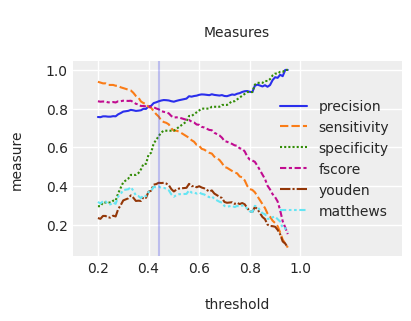

In [33]:
graph = delta.graphing.error.Error(blob=T, which='dependent')
graph.exc(optimal=optimal)

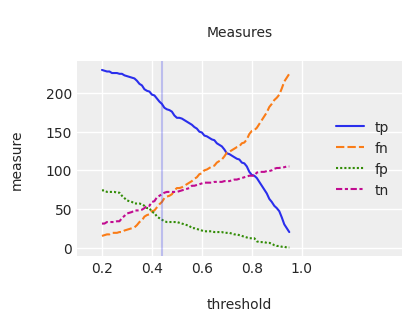

In [34]:
graph = delta.graphing.error.Error(blob=T, which='independent')
graph.exc(optimal=optimal)

<br>
<br>

### Disaggregated

The reference data set, which includes the

* original forms of embedded polytomous categorical fields
* classification plausibilities
* field of estimated/assigned class w.r.t. plausibilities and a threshold

In [35]:
reference = testingdata.copy()
reference.loc[:, 'estimated'] = (plausibilities > optimal).astype(int)
reference.loc[:, 'plausibilities'] = plausibilities

<br>

Hence

In [36]:
fields = ['female', 'A192', 'credit_history']
disaggregates = delta.binary.disaggregates.Disaggregates(
    fields=fields, properties=properties)

In [37]:
J = disaggregates.exc(blob=reference)

logger.warning('J: %s', J.shape)
J.dropna(axis=0, how='any', inplace=True)
J.reset_index(drop=True, inplace=True)
logger.warning('\nJ: %s', J.shape)

J: (684, 15)
2021-07-19 01:59:40.760

J: (652, 15)
2021-07-19 01:59:40.770


In [38]:
J.tail()

,threshold,tp,fn,tn,fp,precision,sensitivity,specificity,fscore,youden,matthews,balanced_accuracy,standard_accuracy,field,element
647,0.91,2,22,9,0,1.0,0.083333,1.0,0.153846,0.083333,0.155543,0.541667,0.727273,credit_history,A33
648,0.92,1,23,9,0,1.0,0.041667,1.0,0.080000,0.041667,0.108253,0.520833,0.727273,credit_history,A33
649,0.93,1,23,9,0,1.0,0.041667,1.0,0.080000,0.041667,0.108253,0.520833,0.727273,credit_history,A33
650,0.94,1,23,9,0,1.0,0.041667,1.0,0.080000,0.041667,0.108253,0.520833,0.727273,credit_history,A33
651,0.95,1,23,9,0,1.0,0.041667,1.0,0.080000,0.041667,0.108253,0.520833,0.727273,credit_history,A33


<br>
<br>
<br>

## Graphing

The definitions of the categorical fields

In [39]:
with open(os.path.join('data', 'definitionsOfCategories.json'), 'r') as blob:
    definitions = json.load(blob)

<br>

Arguments

In [40]:
Arguments = collections.namedtuple(typename='Arguments', field_names=['optimal', 'definitions', 'directory'])

<br>

### Overarching

In [41]:
arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'overarching')))

In [42]:
pamphlet = delta.binary.pamphlet.overarching.Overarching(blob=T, arguments=arguments)
pamphlet.exc()

<br>

### Disaggregates

In [43]:
arguments = Arguments._make((optimal, definitions, os.path.join(directory, 'disaggregates')))

In [44]:
for field in fields:

    blob = J[J['field'] == field]
    elements = blob['element'].unique()

    pamphlet = delta.binary.pamphlet.disaggregates.Disaggregates(
        field=field, elements=elements, blob=blob, arguments=arguments)
    
    pamphlet.exc()

<br>
<br>

## Persist

In [45]:
T.to_csv(path_or_buf=os.path.join(directory, 'overarching', 'overarching.csv'), header=True, 
                   index=False, encoding='UTF-8')

In [46]:
J.to_csv(path_or_buf=os.path.join(directory, 'disaggregates', 'disaggregates.csv'), header=True, 
                     index=False, encoding='UTF-8')

<br>
<br>

## Aside

In [47]:
!rm -rf evaluations.zip
!zip -r evaluations.zip warehouse/evaluations/

  adding: warehouse/evaluations/ (stored 0%)
  adding: warehouse/evaluations/disaggregates/ (stored 0%)
  adding: warehouse/evaluations/disaggregates/metrics/ (stored 0%)
  adding: warehouse/evaluations/disaggregates/metrics/female.json (deflated 86%)
  adding: warehouse/evaluations/disaggregates/metrics/credit_history.json (deflated 91%)
  adding: warehouse/evaluations/disaggregates/metrics/A192.json (deflated 86%)
  adding: warehouse/evaluations/disaggregates/disaggregates.csv (deflated 82%)
  adding: warehouse/evaluations/disaggregates/frequencies/ (stored 0%)
  adding: warehouse/evaluations/disaggregates/frequencies/female.json (deflated 87%)
  adding: warehouse/evaluations/disaggregates/frequencies/credit_history.json (deflated 90%)
  adding: warehouse/evaluations/disaggregates/frequencies/A192.json (deflated 87%)
  adding: warehouse/evaluations/overarching/ (stored 0%)
  adding: warehouse/evaluations/overarching/overarching.csv (deflated 69%)
  adding: warehouse/evaluations/overa